## Detecting Fake News and Real News

This aim of this project is to detect fake new, using date from buzz feeds and politifacts. We will perfrom machine learning on the data and test the perfromance of popular machine algorithm to evalute their performance.

- Frame the problem
- Get the data
- Explore the data to gain insights
- Prepare the data to better expose the underlying data patterens to machien learning algorithm
- Explore many model and shorlist the best ones
- Fine tune the model and combine it into a great solution
- Present the solution
- Launch and monitor the systems

In [1]:
# Importing usefull libraries 

import numpy as np
import scipy.sparse
import scipy.sparse.csgraph

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

import csv
import textstat as ts
import re


/home/eviofekeze/anaconda3/envs/tf2/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Importing Machine Learning Libraries 
import xgboost as xg
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, make_scorer, roc_auc_score, average_precision_score, precision_score, f1_score

### The Data
Here we discuss the data

Politifact: Load and Format News Content Data

In [3]:

temp = pd.read_json('PolitiFact/RealNewsContent/PolitiFact_Real_2-Webpage.json',orient='index')

# get real news content data
politifact_real_news =  pd.DataFrame(columns=temp.index) # Inititalize an empty dataframce
# loop over all 
for i in range(1,121):
    path='PolitiFact/RealNewsContent/PolitiFact_Real_'+str(i)+'-Webpage.json'
    df = pd.read_json(path,orient='index')
    df = df.transpose()
    politifact_real_news = pd.concat([politifact_real_news , df])

# clear memory
del(df,path,i)


#get fake news content data
politifact_fake_news =  pd.DataFrame(columns=temp.index)
for i in range(1,121):
    path='PolitiFact/FakeNewsContent/PolitiFact_Fake_'+str(i)+'-Webpage.json'
    df = pd.read_json(path,orient='index')
    df = df.transpose()
    politifact_fake_news = pd.concat([politifact_fake_news, df])

# Clear memory
del(df,path,i,temp)


#Assigning classes
politifact_fake_news['Real'] = 0
politifact_real_news['Real'] = 1

In [4]:
print(politifact_real_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 0
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   top_img         118 non-null    object
 1   text            120 non-null    object
 2   authors         118 non-null    object
 3   keywords        118 non-null    object
 4   meta_data       118 non-null    object
 5   canonical_link  118 non-null    object
 6   images          118 non-null    object
 7   title           120 non-null    object
 8   url             118 non-null    object
 9   summary         118 non-null    object
 10  movies          118 non-null    object
 11  publish_date    81 non-null     object
 12  source          118 non-null    object
 13  Real            120 non-null    int64 
dtypes: int64(1), object(13)
memory usage: 14.1+ KB
None


In [5]:
politifact_real_news = politifact_real_news.reset_index(drop=True)
politifact_real_news.head()

,top_img,text,authors,keywords,meta_data,canonical_link,images,title,url,summary,movies,publish_date,source,Real
0,http://occupydemocrats.com/wp-content/uploads/...,16.8k SHARES SHARE THIS STORY\n\nHillary Clint...,"[Brett Bose, Grant Stern, Steve Bernstein, Nat...",[],{'generator': 'Powered by Visual Composer - dr...,http://occupydemocrats.com/2016/09/27/trump-ju...,[http://occupydemocrats.com/wp-content/uploads...,Trump Just Insulted Millions Who Lost Everythi...,http://occupydemocrats.com/2016/09/27/trump-ju...,,[],{'$date': 1474934400000},http://occupydemocrats.com,1
1,http://occupydemocrats.com/wp-content/uploads/...,24.8k SHARES SHARE THIS STORY\n\nRepublican no...,"[Colin Taylor, Grant Stern, Brett Bose, Natali...",[],{'generator': 'Powered by Visual Composer - dr...,http://occupydemocrats.com/2016/09/22/unhinged...,[http://occupydemocrats.com/wp-content/uploads...,Trump Campaign Chair Says Racism Didn't Exist ...,http://occupydemocrats.com/2016/09/22/unhinged...,,[],{'$date': 1474502400000},http://occupydemocrats.com,1
2,NaN,The University of North Dakota is investigatin...,NaN,NaN,NaN,NaN,NaN,'Locked the black bitch out': White students u...,NaN,NaN,NaN,NaN,NaN,1
3,http://occupydemocrats.com/wp-content/uploads/...,12k SHARES SHARE THIS STORY\n\nMassive protest...,"[Colin Taylor, Grant Stern, Brett Bose, Natali...",[],{'generator': 'Powered by Visual Composer - dr...,http://occupydemocrats.com/2016/09/21/massive-...,[http://occupydemocrats.com/wp-content/uploads...,Massive Protests Erupt In North Carolina After...,http://occupydemocrats.com/2016/09/21/massive-...,,[],{'$date': 1474416000000},http://occupydemocrats.com,1
4,http://addictinginfo.addictinginfoent.netdna-c...,"In the first half of the debate, Donald Trump ...",[Ryan Denson],[],{'publisher': 'Addicting Info | The Knowledge ...,http://addictinginfo.com/2016/09/27/howard-dea...,"[http://i.imgur.com/JeqZLhj.png, https://d5nxs...",Howard Dean ROASTS Trump Over Debate Sniffles:...,http://addictinginfo.org/2016/09/27/howard-dea...,,[],{'$date': 1474934400000},http://addictinginfo.org,1


In [6]:
print(politifact_fake_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 0
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   top_img         91 non-null     object
 1   text            120 non-null    object
 2   authors         91 non-null     object
 3   keywords        91 non-null     object
 4   meta_data       91 non-null     object
 5   canonical_link  91 non-null     object
 6   images          91 non-null     object
 7   title           120 non-null    object
 8   url             91 non-null     object
 9   summary         91 non-null     object
 10  movies          91 non-null     object
 11  publish_date    83 non-null     object
 12  source          91 non-null     object
 13  Real            120 non-null    int64 
dtypes: int64(1), object(13)
memory usage: 14.1+ KB
None


In [7]:
politifact_fake_news = politifact_fake_news.reset_index(drop=True)
politifact_fake_news.head()

,top_img,text,authors,keywords,meta_data,canonical_link,images,title,url,summary,movies,publish_date,source,Real
0,http://occupydemocrats.com/wp-content/uploads/...,335 SHARES SHARE THIS STORY\n\nRepublican atta...,[Colin Taylor],[],{'generator': 'Powered by Visual Composer - dr...,http://occupydemocrats.com/2016/01/12/virginia...,[http://occupydemocrats.com/wp-content/uploads...,Virginia Republican Wants Schools To Check Chi...,http://www.occupydemocrats.com/virginia-republ...,,[],{'$date': 1452628948000},http://www.occupydemocrats.com,0
1,http://www.americanpoliticnews.com/wp-content/...,Denzel Washington Switches to Trump Shocks Hol...,[],[],"{'og': {'site_name': 'American Politic', 'desc...",http://www.americanpoliticnews.com/news/denzel...,[http://www.americanpoliticnews.com/wp-content...,Denzel Washington Switches to Trump Shocks Hol...,http://www.americanpoliticnews.com/news/denzel...,,[],{'$date': 1472491609000},http://www.americanpoliticnews.com,0
2,http://dailysnark.com/wp-content/uploads/2016/...,Ad\n\nYou may asked what the Unites States did...,[],[],{'generator': 'Powered by Slider Revolution 5....,http://dailysnark.com/harambe-dead-gorilla-got...,[http://dailysnark.com/wp-content/uploads/2016...,"Harambe, A Dead Gorilla, Got Over 15,000 Votes...",http://dailysnark.com/harambe-dead-gorilla-got...,,[],{'$date': 1478666395000},http://dailysnark.com,0
3,https://cdn.vox-cdn.com/thumbor/sye0FzRVD4YBWJ...,"Last night, a twitter account by the name of @...",[Nov Est],[],"{'outbrainsection': 'us-world', 'msapplication...",https://www.theverge.com/2016/11/25/13748226/c...,[https://cdn.vox-cdn.com/thumbor/BDjczkjZSskRO...,The CNN porn scare is how fake news spreads,http://www.theverge.com/2016/11/25/13748226/cn...,,[],{'$date': 1480032000000},http://www.theverge.com,0
4,http://spinzon.com/wp-content/uploads/2016/11/...,Lady Gaga has opened up about the perils of fa...,[],[],{'description': 'Gaga also said that she finds...,http://spinzon.com/lady-gaga-reveals-plan-cove...,[https://i0.wp.com/assets.pinterest.com/images...,Lady Gaga Reveals Plan To Cover Her Face Again...,http://spinzon.com/lady-gaga-reveals-plan-cove...,,[],{'$date': 1480072046000},http://spinzon.com,0


In [8]:
politifact_news = pd.concat([politifact_real_news, politifact_fake_news], ignore_index=True)
politifact_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   top_img         209 non-null    object
 1   text            240 non-null    object
 2   authors         209 non-null    object
 3   keywords        209 non-null    object
 4   meta_data       209 non-null    object
 5   canonical_link  209 non-null    object
 6   images          209 non-null    object
 7   title           240 non-null    object
 8   url             209 non-null    object
 9   summary         209 non-null    object
 10  movies          209 non-null    object
 11  publish_date    164 non-null    object
 12  source          209 non-null    object
 13  Real            240 non-null    int64 
dtypes: int64(1), object(13)
memory usage: 26.4+ KB


In [9]:
#get real news content data
temp = pd.read_json('BuzzFeed/RealNewsContent/BuzzFeed_Real_2-Webpage.json',orient='index')
buzzfeed_real_news =  pd.DataFrame(columns=temp.index)
for i in range(1,92):
    path='BuzzFeed/RealNewsContent/BuzzFeed_Real_'+str(i)+'-Webpage.json'
    df = pd.read_json(path,orient='index')
    df = df.transpose()
    buzzfeed_real_news = pd.concat([buzzfeed_real_news,df])


#clear memory
del(df,path,i)

#get fake news content data
buzzfeed_fake_news =  pd.DataFrame(columns=temp.index)
for i in range(1,92):
    path='BuzzFeed/FakeNewsContent/BuzzFeed_Fake_'+str(i)+'-Webpage.json'
    df = pd.read_json(path,orient='index')
    df = df.transpose()
    buzzfeed_fake_news = pd.concat([buzzfeed_fake_news, df])

#clear memory
del(df,path,i,temp)


buzzfeed_fake_news['Real'] = 0
buzzfeed_real_news['Real'] = 1

In [10]:
buzzfeed_real_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 0 to 0
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   top_img         91 non-null     object
 1   text            91 non-null     object
 2   authors         91 non-null     object
 3   keywords        91 non-null     object
 4   meta_data       91 non-null     object
 5   canonical_link  91 non-null     object
 6   images          91 non-null     object
 7   title           91 non-null     object
 8   url             91 non-null     object
 9   summary         91 non-null     object
 10  movies          91 non-null     object
 11  publish_date    56 non-null     object
 12  source          91 non-null     object
 13  Real            91 non-null     int64 
dtypes: int64(1), object(13)
memory usage: 10.7+ KB


In [11]:
buzzfeed_real_news = buzzfeed_real_news.reset_index(drop=True)
buzzfeed_real_news.head()

,top_img,text,authors,keywords,meta_data,canonical_link,images,title,url,summary,movies,publish_date,source,Real
0,http://eaglerising.com/wp-content/uploads/2016...,"On Saturday, September 17 at 8:30 pm EST, an e...","[View All Posts, Leonora Cravotta]",[],{'description': '“We believe at this point in ...,http://eaglerising.com/36942/another-terrorist...,[http://constitution.com/wp-content/uploads/20...,Another Terrorist Attack in NYC…Why Are we STI...,http://eaglerising.com/36942/another-terrorist...,,[],{'$date': 1474528230000},http://eaglerising.com,1
1,http://i2.cdn.cnn.com/cnnnext/dam/assets/16091...,"Story highlights ""This, though, is certain: to...","[Mj Lee, Cnn National Politics Reporter]",[],{'description': 'Hillary Clinton kicked off a ...,http://www.cnn.com/2016/09/21/politics/hillary...,[http://i2.cdn.cnn.com/cnnnext/dam/assets/1609...,Hillary Clinton on police shootings: 'too many...,http://cnn.it/2cRxlv5,,[],None,http://cnn.it,1
2,http://i2.cdn.cnn.com/cnnnext/dam/assets/16091...,Critical Counties is a CNN series exploring 11...,"[Joyce Tseng, Eli Watkins]",[],"{'pubdate': '2016-09-23T16:55:31Z', 'author': ...",http://www.cnn.com/2016/09/23/politics/critica...,[http://i2.cdn.cnn.com/cnnnext/dam/assets/1609...,"Critical counties: Wake County, NC, could put ...",http://cnn.it/2dnoYpa,,[],None,http://cnn.it,1
3,http://conservativetribune.com/wp-content/uplo...,McCain Criticized Trump for Arpaio’s Pardon… S...,[],[],"{'viewport': 'width=device-width, initial-scal...",,[http://static.westernjournalism.com/wp-conten...,NFL Superstar Unleashes 4 Word Bombshell on Re...,http://conservativebyte.com/2016/09/inside-the...,,[],None,http://conservativebyte.com,1
4,http://i2.cdn.cnn.com/cnnnext/dam/assets/16091...,Story highlights Obams reaffirms US commitment...,"[Kevin Liptak, Cnn White House Producer]",[],{'description': 'President Barack Obama worked...,http://www.cnn.com/2016/09/19/politics/obama-t...,[http://i2.cdn.cnn.com/cnnnext/dam/assets/1609...,Obama in NYC: 'We all have a role to play' in ...,http://cnn.it/2cTtbDk,,[],None,http://cnn.it,1


In [12]:
buzzfeed_fake_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 0 to 0
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   top_img         83 non-null     object
 1   text            91 non-null     object
 2   authors         83 non-null     object
 3   keywords        83 non-null     object
 4   meta_data       83 non-null     object
 5   canonical_link  83 non-null     object
 6   images          83 non-null     object
 7   title           91 non-null     object
 8   url             83 non-null     object
 9   summary         83 non-null     object
 10  movies          83 non-null     object
 11  publish_date    77 non-null     object
 12  source          83 non-null     object
 13  Real            91 non-null     int64 
dtypes: int64(1), object(13)
memory usage: 10.7+ KB


In [13]:
buzzfeed_fake_news = buzzfeed_fake_news.reset_index(drop=True)
buzzfeed_fake_news.head()

,top_img,text,authors,keywords,meta_data,canonical_link,images,title,url,summary,movies,publish_date,source,Real
0,http://addictinginfo.addictinginfoent.netdna-c...,I woke up this morning to find a variation of ...,[Wendy Gittleson],[],{'publisher': 'Addicting Info | The Knowledge ...,http://addictinginfo.com/2016/09/19/proof-the-...,"[http://i.imgur.com/JeqZLhj.png, http://addict...",Proof The Mainstream Media Is Manipulating The...,http://www.addictinginfo.org/2016/09/19/proof-...,,[],{'$date': 1474243200000},http://www.addictinginfo.org,0
1,http://usherald.com/wp-content/uploads/2015/05...,Thanks in part to the declassification of Defe...,[Bob Amoroso],[],"{'generator': 'WordPress 4.8.1', 'og': {'site_...",http://usherald.com/breaking-declassified-docs...,[http://usherald.com/wp-content/uploads/2015/0...,Declassified Docs Show That Obama Admin Create...,http://usherald.com/breaking-declassified-docs...,,[],{'$date': 1432650030000},http://usherald.com,0
2,http://eaglerising.com/wp-content/uploads/2016...,The Democrats are using an intimidation tactic...,[View All Posts],[],{'description': 'There is evidence the birth c...,http://eaglerising.com/36841/why-is-it-racist-...,[http://2lv0hm3wvpix464wwy2zh7d1.wpengine.netd...,Why is it “RACIST” to Question Someone’s Birth...,http://eaglerising.com/36841/why-is-it-racist-...,,[],{'$date': 1474243356000},http://eaglerising.com,0
3,http://100percentfedup.com/wp-content/uploads/...,Dolly Kyle has written a scathing “tell all” b...,[Fed Up],[],"{'googlebot': 'noimageindex', 'generator': 'Po...",http://100percentfedup.com/hillary-on-disabled...,[https://www.facebook.com/tr?id=15790889156864...,HILLARY ON DISABLED CHILDREN During Easter Egg...,http://100percentfedup.com/hillary-on-disabled...,,[],{'$date': 1466439263000},http://100percentfedup.com,0
4,http://clashdaily.com/wp-content/uploads/2016/...,The Haitians in the audience have some newswor...,"[Rich Witmer, Doug Giles]",[],"{'googlebot': 'noimageindex', 'og': {'site_nam...",http://clashdaily.com/2016/09/watch-trump-visi...,[http://clashdaily.wpengine.netdna-cdn.com/wp-...,'Reporters' FLEE When Clintons Get EXPOSED!,http://clashdaily.com/2016/09/watch-trump-visi...,,[https://www.youtube.com/embed/x5IS6Ya005E?fea...,{'$date': 1474208802000},http://clashdaily.com,0


In [14]:
buzzfeed_news = pd.concat([buzzfeed_real_news, buzzfeed_fake_news], ignore_index=True)
buzzfeed_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   top_img         174 non-null    object
 1   text            182 non-null    object
 2   authors         174 non-null    object
 3   keywords        174 non-null    object
 4   meta_data       174 non-null    object
 5   canonical_link  174 non-null    object
 6   images          174 non-null    object
 7   title           182 non-null    object
 8   url             174 non-null    object
 9   summary         174 non-null    object
 10  movies          174 non-null    object
 11  publish_date    133 non-null    object
 12  source          174 non-null    object
 13  Real            182 non-null    int64 
dtypes: int64(1), object(13)
memory usage: 20.0+ KB


In [15]:
news = pd.concat([politifact_news, buzzfeed_news], ignore_index=True)
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   top_img         383 non-null    object
 1   text            422 non-null    object
 2   authors         383 non-null    object
 3   keywords        383 non-null    object
 4   meta_data       383 non-null    object
 5   canonical_link  383 non-null    object
 6   images          383 non-null    object
 7   title           422 non-null    object
 8   url             383 non-null    object
 9   summary         383 non-null    object
 10  movies          383 non-null    object
 11  publish_date    297 non-null    object
 12  source          383 non-null    object
 13  Real            422 non-null    int64 
dtypes: int64(1), object(13)
memory usage: 46.3+ KB


In [16]:
news.columns

Index(['top_img', 'text', 'authors', 'keywords', 'meta_data', 'canonical_link',
       'images', 'title', 'url', 'summary', 'movies', 'publish_date', 'source',
       'Real'],
      dtype='object')

In [17]:
train, test = train_test_split(news, test_size=0.25, random_state=42)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316 entries, 18 to 102
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   top_img         285 non-null    object
 1   text            316 non-null    object
 2   authors         285 non-null    object
 3   keywords        285 non-null    object
 4   meta_data       285 non-null    object
 5   canonical_link  285 non-null    object
 6   images          285 non-null    object
 7   title           316 non-null    object
 8   url             285 non-null    object
 9   summary         285 non-null    object
 10  movies          285 non-null    object
 11  publish_date    217 non-null    object
 12  source          285 non-null    object
 13  Real            316 non-null    int64 
dtypes: int64(1), object(13)
memory usage: 37.0+ KB


In [18]:
train_x = train.drop(columns=['Real'])
test_x = test.drop(columns=['Real'])


train_y = train['Real']
test_y = test['Real']

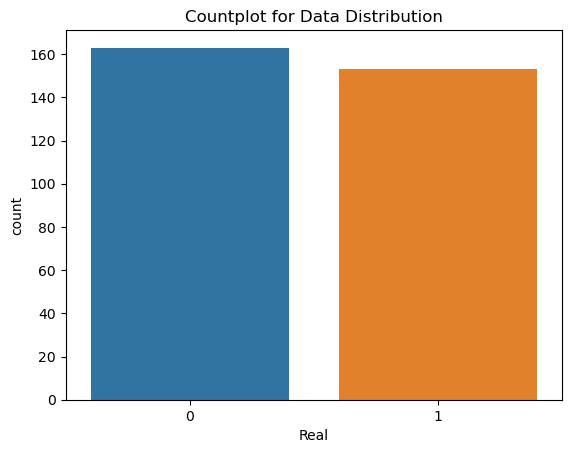

In [19]:
sns.countplot(x = train['Real'])
plt.title("Countplot for Data Distribution")
plt.show()

## Feature Engineering: News Content

In [20]:
import emoji
# from emoji import UNICODE_EMOJI
from emoji import unicode_codes
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/eviofekeze/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/eviofekeze/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
# list(emoji.unicode_codes.EMOJI_DATA)

In [22]:
def num_all_caps(string):
    if len(re.findall(r"([A-Z]+\s?[A-Z]+[^a-z0-9\W])",string)) > 0:
      return 0
    return 1
    # return len(re.findall(r"([A-Z]+\s?[A-Z]+[^a-z0-9\W])",string))
def num_exmarks(string):
    if string.count("!") > 0:
      return 0
    return 1
    # return string.count("!") 

def num_all_caps_or_exmarks(string):
    if len(re.findall(r"([A-Z]+\s?[A-Z]+[^a-z0-9\W])",string)) > 0:
      return 0
    if string.count("!") > 0:
      return 0
    return 1

def title_ln(text):
  totalln = 0 
  for character in word_tokenize(text):
      totalln +=1
  if totalln > 11:
    return 0
  return 1
  # return totalln
def text_ln(text):
  totalln = 0 
  for character in word_tokenize(text):
      totalln +=1
  if totalln > 500:
    return 1
  return 0
  # return totalln
def text_has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            return 1
    return 0
def text_word_len(text):
  longln = 0
  totalln = 0 
  for character in word_tokenize(text):
    if character not in stop_words:
      if len(character) > 6:
        longln += 1
      totalln +=1
  if totalln != 0:
    if longln / totalln > 0.3:
      return 0
  return 1
  # if totalln != 0:
  #   return longln / totalln
  # return 0
def stop_word_title(text):
  stopln = 0
  totalln = 0 
  for character in word_tokenize(text):
    if character in stop_words:
        stopln += 1
    totalln +=1
  if totalln != 0:
    if stopln / totalln > 0.14:
      return 1
  return 0
  # if totalln != 0:
  #   return stopln / totalln
  # return 0
def stop_word_text(text):
  stopln = 0
  totalln = 0 
  for character in word_tokenize(text):
    if character in stop_words:
        stopln += 1
    totalln +=1
  if totalln != 0:
    if stopln / totalln > 0.37:
      return 1
  return 0
  # if totalln != 0:
  #   return stopln / totalln
  # return 0
news['title_allcaps']=news['title'].apply(num_all_caps)
news['title_num_exmarks'] = news['title'].apply(num_exmarks)
news['title_allcaps_or_exmarks']=news['title'].apply(num_all_caps_or_exmarks)
news['title_length']=news['title'].apply(title_ln)
news['text_length']=news['text'].apply(text_ln)
# news['title_isascii']=news['title'].apply(text_has_emoji)
# news['text_isascii']=news['text'].apply(text_has_emoji)
news['title_comp']=news['title'].apply(text_word_len)
news['text_comp']=news['text'].apply(text_word_len)
news['title_stopwords']=news['title'].apply(stop_word_title)
news['text_stopwords']=news['text'].apply(stop_word_text)
# Readability Scores
# news['flesch_score'] =news['text'].apply(ts.flesch_reading_ease).apply(lambda x: x**2)
news['flesch_score'] =news['text'].apply(ts.flesch_reading_ease)
news['dale_chall_score'] =news['text'].apply(ts.dale_chall_readability_score)

In [23]:
# def myfucn(X, *args):
#   res = len(str(X['text'])) 
#   return res


# def myfucnagain(X, *args):
#   res = len(re.findall(r"([A-Z]+\s?[A-Z]+[^a-z0-9\W])",str(X['text']))) > 0
#   return res



In [24]:
def myfucnagain(X, *args):
  res = len(X['title'])
  # res = tres > 0 
  return res.to_frame('Test')

In [25]:
# FunctionTransformer(num_all_caps).fit_transform(train_x)
# .to_frame('NumAllCaps')

In [26]:
feature_prep = ColumnTransformer([
    # ('StopWordsTitle', FunctionTransformer(stop_word_title), ['title']),
    # ('StopWordsText', FunctionTransformer(stop_word_text), ['text']),
    # ('Text_Word_Len', FunctionTransformer(text_word_len), ['text']),
    # ('Title_Word_Len', FunctionTransformer(text_word_len), ['title']),
    # ('Text_Has_emoji', FunctionTransformer(text_has_emoji), ['text']),
    # ('Title_Has_emoji', FunctionTransformer(text_has_emoji), ['title']),
    # ('TextLength', FunctionTransformer(text_ln), ['text']),
    # ('TitleLength', FunctionTransformer(title_ln), ['title']),
    # ('NumAllCap', FunctionTransformer(num_all_caps_or_exmarks), ['title']),
    # ('NumExMarks', FunctionTransformer(num_exmarks), ['title']),
    # ('NumExMarks', FunctionTransformer(num_exmarksi), ['title']),
    # ('NumAllCaps', FunctionTransformer(num_all_caps), ['title'])
])

In [41]:
# feature_prep.fit_transform(train_x)

### Select Features

In [28]:
feature_list = ['title_allcaps','title_num_exmarks','title_length',
               'text_length','flesch_score','dale_chall_score', 'title_comp', 
                'text_comp', 'title_stopwords', 'text_stopwords', 
               'Real',"title_allcaps_or_exmarks"]
news_ft = news[feature_list].copy()
# news_ft['num_shared']=news_ft['num_shared'].astype('int')
news_ft['Real']=news_ft['Real'].astype('int')
news_ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title_allcaps             422 non-null    int64  
 1   title_num_exmarks         422 non-null    int64  
 2   title_length              422 non-null    int64  
 3   text_length               422 non-null    int64  
 4   flesch_score              422 non-null    float64
 5   dale_chall_score          422 non-null    float64
 6   title_comp                422 non-null    int64  
 7   text_comp                 422 non-null    int64  
 8   title_stopwords           422 non-null    int64  
 9   text_stopwords            422 non-null    int64  
 10  Real                      422 non-null    int64  
 11  title_allcaps_or_exmarks  422 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 39.7 KB


## Modelling

In [29]:

metrics_dict={
'XgBoost':{'accuracy':0,'precision':0,'recall':0,'f1':0},
'Naive Bayes':{'accuracy':0,'precision':0,'recall':0,'f1':0},
'Support Vector Machine':{'accuracy':0,'precision':0,'recall':0,'f1':0},
'Decision Tree':{'accuracy':0,'precision':0,'recall':0,'f1':0},
'Random Forest Classifier':{'accuracy':0,'precision':0,'recall':0,'f1':0},
'Voting Classifier':{'accuracy':0,'precision':0,'recall':0,'f1':0}}

metrics_df = pd.DataFrame.from_dict(metrics_dict,orient='index')

### XG Boost

In [31]:
#X= news_ft.drop(columns=['Real'])
X_ft = news_ft[[          
          'text_length',
          'flesch_score',
          'dale_chall_score',
          'title_allcaps_or_exmarks',
          'title_num_exmarks',
          'title_length',
          'title_comp', 
          'text_comp', 
          'title_stopwords', 
          'text_stopwords',
          ]]
y = news_ft['Real']
# y = news['Real']

count = CountVectorizer(stop_words='english')
X_txt = count.fit_transform(news['text'])
X_txt = X_txt.todense()

X = np.hstack((X_ft,X_txt))
X=X.astype('float')
y = y.astype('int')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

precision_list=[]
recall_list=[]
f1_list=[]
accuracy_list=[]
auc_scores=[]
AVG_precision_scores=[]

#X = X.to_numpy()
y = y.to_numpy()


param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'error'
num_round = 10

for tr_ind, tst_ind in skf.split(X,y):
    X_train = X[tr_ind,:]
    X_test = X[tst_ind,:]
    y_train = y[tr_ind]
    y_test = y[tst_ind]
    # evallist = [(dtest, 'eval'), (dtrain, 'train')]
    #classification
    xg_clf = xg.XGBClassifier(max_depth=10, learning_rate=0.5, n_estimators=8, use_label_encoder=False,
                       objective='binary:logistic', booster='gbtree',min_child_weight=10,eval_metric='error')
    xg_clf.fit(X_train, y_train)  
    # predict the labels on test dataset
    predictions = xg_clf.predict(X_test)

    #evaluation
    precision_list.append(metrics.precision_score(y_test, predictions))
    recall_list.append(metrics.recall_score(y_test, predictions))
    f1_list.append(metrics.f1_score(y_test, predictions))
    accuracy_list.append(metrics.accuracy_score(y_test,predictions))
    auc_scores.append(roc_auc_score(y_test, predictions))
    AVG_precision_scores.append(average_precision_score(y_test, predictions))

metrics_df.loc['XgBoost','precision'] =  round(np.mean(precision_list)*100,3)
metrics_df.loc['XgBoost','recall'] = round(np.mean(recall_list)*100,3)
metrics_df.loc['XgBoost','f1'] = round(np.mean(f1_list)*100,3)
metrics_df.loc['XgBoost','accuracy'] = round(np.mean(accuracy_list)*100,3)

print(" precision  = ", round(np.mean(precision_list)*100,3),"\n", 
      "recall     = ",round(np.mean(recall_list)*100,3),"\n",
      "f1         = ",round(np.mean(f1_list)*100,3),"\n",
      "accuracy   = ",round(np.mean(accuracy_list)*100,3),"\n", 
      "AUROC      = ", round(np.mean(auc_scores)*100,3),"\n",
      "Average Precision = ", round(np.mean(AVG_precision_scores)*100,3),"\n", )

 precision  =  76.974 
 recall     =  68.726 
 f1         =  72.523 
 accuracy   =  73.952 
 AUROC      =  73.942 
 Average Precision =  68.598 



### Naive Bayes


In [32]:
wordCount = CountVectorizer(stop_words='english')
wordCount = wordCount.fit(news['text'])
text_vector = wordCount.transform(news['text'])

temp = text_vector.toarray()
text_vector_df = pd.DataFrame(temp, columns=[f'TV{i}' for i in range(15428)], index=news.index)
new_df = news_ft.join(text_vector_df, on = news_ft.index)

In [33]:
# X = text_vector_df.join(news_ft[['title_allcaps','dale_chall_score','title_num_exmarks','f_ratio','shared_by_top', 
#                         'title_allcaps_or_exmarks','title_comp', 'text_comp', 'title_stopwords', 'text_stopwords']], on=news_ft.index)
X = text_vector_df.join(news_ft[['title_allcaps','dale_chall_score','title_num_exmarks']], on=news_ft.index)

y = new_df['Real'].astype('i4')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

precision_list=[]
recall_list=[]
f1_list=[]
accuracy_list=[]
auc_scores = []
AVG_precision_scores = []


for tr_ind, tst_ind in skf.split(X,y):
  X_train = X.iloc[tr_ind]
  X_test = X.iloc[tst_ind]
  y_train = y[tr_ind]
  y_test = y[tst_ind]

  mn_clf = MultinomialNB()
  mn_clf.fit(X_train, y_train) 
  predictions = mn_clf.predict(X_test)
  proba = mn_clf.predict_proba(X_test)[:,1]
      

    #evaluation
  precision = metrics.precision_score(y_test, predictions)
  recall = metrics.recall_score(y_test, predictions)
  f1 = metrics.f1_score(y_test, predictions)
  accuracy = metrics.accuracy_score(y_test,predictions)
      # print(metrics.confusion_matrix(y_test,predictions))
      
  precision_list.append(precision)
  recall_list.append(recall)
  f1_list.append(f1)
  accuracy_list.append(accuracy)
  auc_scores.append(roc_auc_score(y_test, proba))
  AVG_precision_scores.append(average_precision_score(y_test, proba))

metrics_df.loc['Naive Bayes','precision'] = round(np.mean(precision_list)*100,3)
metrics_df.loc['Naive Bayes','recall'] = round(np.mean(recall_list)*100,3)
metrics_df.loc['Naive Bayes','f1'] = round(np.mean(f1_list)*100,3)
metrics_df.loc['Naive Bayes','accuracy'] = round(np.mean(accuracy_list)*100,3)

print(" precision  = ", round(np.mean(precision_list)*100,3),"\n", 
      "recall     = ",round(np.mean(recall_list)*100,3),"\n",
      "f1         = ",round(np.mean(f1_list)*100,3),"\n",
      "accuracy   = ",round(np.mean(accuracy_list)*100,3),"\n", 
      "AUROC      = ", round(np.mean(auc_scores)*100,3),"\n",
      "Average Precision = ", round(np.mean(AVG_precision_scores)*100,3),"\n", )

 precision  =  81.637 
 recall     =  83.422 
 f1         =  82.459 
 accuracy   =  82.241 
 AUROC      =  86.302 
 Average Precision =  84.905 



### Support Vector Machine

In [34]:
wordCount = TfidfVectorizer(stop_words='english')
wordCount = wordCount.fit(news['text'])
text_vector = wordCount.transform(news['text'])

temp = text_vector.toarray()
text_vector_df = pd.DataFrame(temp, columns=[f'TV{i}' for i in range(15428)], index=news.index)
new_df = news_ft.join(text_vector_df, on = news_ft.index)

In [36]:
X = text_vector_df.join(news_ft[['title_allcaps','dale_chall_score','title_num_exmarks',
          'title_comp', 'text_comp', 'title_stopwords', 'text_stopwords']], on=news_ft.index)
y = new_df['Real'].astype('i4')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

precision_list=[]
recall_list=[]
f1_list=[]
accuracy_list=[]
auc_scores = []
AVG_precision_scores = []


for tr_ind, tst_ind in skf.split(X,y):
  X_train = X.iloc[tr_ind]
  X_test = X.iloc[tst_ind]
  y_train = y[tr_ind]
  y_test = y[tst_ind]

  sv_clf = svm.SVC(kernel= 'rbf', class_weight='balanced',probability=True, decision_function_shape='ovo',C=85)
  sv_clf.fit(X_train, y_train) 
  predictions = sv_clf.predict(X_test)
  proba = sv_clf.predict_proba(X_test)[:,1]
      

    #evaluation
  precision = metrics.precision_score(y_test, predictions)
  recall = metrics.recall_score(y_test, predictions)
  f1 = metrics.f1_score(y_test, predictions)
  accuracy = metrics.accuracy_score(y_test,predictions)
      # print(metrics.confusion_matrix(y_test,predictions))
      
  precision_list.append(precision)
  recall_list.append(recall)
  f1_list.append(f1)
  accuracy_list.append(accuracy)
  auc_scores.append(roc_auc_score(y_test, proba))
  AVG_precision_scores.append(average_precision_score(y_test, proba))

metrics_df.loc['Support Vector Machine','precision'] = round(np.mean(precision_list)*100,3)
metrics_df.loc['Support Vector Machine','recall'] = round(np.mean(recall_list)*100,3)
metrics_df.loc['Support Vector Machine','f1'] = round(np.mean(f1_list)*100,3)
metrics_df.loc['Support Vector Machine','accuracy'] = round(np.mean(accuracy_list)*100,3)

print(" precision  = ", round(np.mean(precision_list)*100,3),"\n", 
      "recall     = ",round(np.mean(recall_list)*100,3),"\n",
      "f1         = ",round(np.mean(f1_list)*100,3),"\n",
      "accuracy   = ",round(np.mean(accuracy_list)*100,3),"\n", 
      "AUROC      = ", round(np.mean(auc_scores)*100,3),"\n",
      "Average Precision = ", round(np.mean(AVG_precision_scores)*100,3),"\n", )

 precision  =  78.628 
 recall     =  75.814 
 f1         =  77.104 
 accuracy   =  77.487 
 AUROC      =  86.649 
 Average Precision =  88.246 



### Decision Tree

In [37]:
wordCount = CountVectorizer(stop_words='english')
wordCount = wordCount.fit(news['text'])
text_vector = wordCount.transform(news['text'])
tnew = news.copy()

temp = text_vector.toarray()
text_vector_df = pd.DataFrame(temp, columns=[f'TV{i}' for i in range(15428)], index=news.index)
new_df = news_ft.join(text_vector_df, on = news_ft.index)
X = text_vector_df.join(news_ft[[          
          'text_length',
          # 'flesch_score',
          'dale_chall_score',
          # 'num_shared',
          # 'avg_follower',
          # 'avg_followee',
          # 'closenness_centrality',
          # 'betweenness_centrality',
          # 'title_allcaps',
          'title_allcaps_or_exmarks',
          # 'title_num_exmarks',
          # 'title_length',
          # 'shared_by_top',
          'title_comp', 
          'text_comp', 
          # 'title_stopwords', 
          # 'text_stopwords',
          # 'f_ratio',
          ]], on=news_ft.index)
y = tnew['Real'].astype('i4')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

precision_list=[]
recall_list=[]
f1_list=[]
accuracy_list=[]
auc_scores = []
AVG_precision_scores = []


for tr_ind, tst_ind in skf.split(X,y):
  X_train = X.iloc[tr_ind]
  X_test = X.iloc[tst_ind]
  y_train = y[tr_ind]
  y_test = y[tst_ind]

  tr_clf = DecisionTreeClassifier( )
  tr_clf = tr_clf.fit(X_train, y_train)
  predictions = tr_clf.predict(X_test)
  proba = tr_clf.predict_proba(X_test)[:,1]
      

    #evaluation
  precision = metrics.precision_score(y_test, predictions)
  recall = metrics.recall_score(y_test, predictions)
  f1 = metrics.f1_score(y_test, predictions)
  accuracy = metrics.accuracy_score(y_test,predictions)
      # print(metrics.confusion_matrix(y_test,predictions))
      
  precision_list.append(precision)
  recall_list.append(recall)
  f1_list.append(f1)
  accuracy_list.append(accuracy)
  auc_scores.append(roc_auc_score(y_test, proba))
  AVG_precision_scores.append(average_precision_score(y_test, proba))

metrics_df.loc['Decision Tree','precision'] = round(np.mean(precision_list)*100,3)
metrics_df.loc['Decision Tree','recall'] = round(np.mean(recall_list)*100,3)
metrics_df.loc['Decision Tree','f1'] = round(np.mean(f1_list)*100,3)
metrics_df.loc['Decision Tree','accuracy'] = round(np.mean(accuracy_list)*100,3)

print(" precision  = ", round(np.mean(precision_list)*100,3),"\n", 
      "recall     = ",round(np.mean(recall_list)*100,3),"\n",
      "f1         = ",round(np.mean(f1_list)*100,3),"\n",
      "accuracy   = ",round(np.mean(accuracy_list)*100,3),"\n", 
      "AUROC      = ", round(np.mean(auc_scores)*100,3),"\n",
      "Average Precision = ", round(np.mean(AVG_precision_scores)*100,3),"\n", )

 precision  =  82.899 
 recall     =  77.265 
 f1         =  79.873 
 accuracy   =  80.339 
 AUROC      =  80.354 
 Average Precision =  75.688 



### Random Forest Classifier

In [38]:
X = text_vector_df.join(news_ft[[          
          # 'title_allcaps',
          'title_allcaps_or_exmarks',
          # 'title_num_exmarks',

          'title_length',
          # 'text_length',

          # 'flesch_score',

          'dale_chall_score',
          # 'num_shared',

          # 'shared_by_top',
          # 'avg_follower',
          'title_comp', 

          'text_comp', 
          'title_stopwords', 
          # 'text_stopwords',
          # 'avg_followee',
          # 'f_ratio',
          # 'closenness_centrality',
          # 'betweenness_centrality',
          ]], on=news_ft.index)
y = tnew['Real'].astype('i4')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

precision_list=[]
recall_list=[]
f1_list=[]
accuracy_list=[]
auc_scores = []
AVG_precision_scores = []


for tr_ind, tst_ind in skf.split(X,y):
  X_train = X.iloc[tr_ind]
  X_test = X.iloc[tst_ind]
  y_train = y[tr_ind]
  y_test = y[tst_ind]

  rnd_clf = RandomForestClassifier(n_estimators= 1000)
  rnd_clf = rnd_clf.fit(X_train, y_train)
  predictions = rnd_clf.predict(X_test)
  proba = rnd_clf.predict_proba(X_test)[:,1]
      

    #evaluation
  precision = metrics.precision_score(y_test, predictions)
  recall = metrics.recall_score(y_test, predictions)
  f1 = metrics.f1_score(y_test, predictions)
  accuracy = metrics.accuracy_score(y_test,predictions)
      # print(metrics.confusion_matrix(y_test,predictions))
      
  precision_list.append(precision)
  recall_list.append(recall)
  f1_list.append(f1)
  accuracy_list.append(accuracy)
  auc_scores.append(roc_auc_score(y_test, proba))
  AVG_precision_scores.append(average_precision_score(y_test, proba))

metrics_df.loc['Random Forest Classifier','precision'] = round(np.mean(precision_list)*100,3)
metrics_df.loc['Random Forest Classifier','recall'] = round(np.mean(recall_list)*100,3)
metrics_df.loc['Random Forest Classifier','f1'] = round(np.mean(f1_list)*100,3)
metrics_df.loc['Random Forest Classifier','accuracy'] = round(np.mean(accuracy_list)*100,3)

print(" precision  = ", round(np.mean(precision_list)*100,3),"\n", 
      "recall     = ",round(np.mean(recall_list)*100,3),"\n",
      "f1         = ",round(np.mean(f1_list)*100,3),"\n",
      "accuracy   = ",round(np.mean(accuracy_list)*100,3),"\n", 
      "AUROC      = ", round(np.mean(auc_scores)*100,3),"\n",
      "Average Precision = ", round(np.mean(AVG_precision_scores)*100,3),"\n", )


 precision  =  82.544 
 recall     =  77.73 
 f1         =  79.976 
 accuracy   =  80.569 
 AUROC      =  88.057 
 Average Precision =  89.099 



### Voting Classifier

In [39]:
from sklearn.ensemble import VotingClassifier
X = text_vector_df.join(news_ft[['title_allcaps','dale_chall_score','title_num_exmarks',
                      'title_comp', 'text_comp', 'title_stopwords', 'text_stopwords']], on=news_ft.index)
y = new_df['Real'].astype('i4')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

precision_list=[]
recall_list=[]
f1_list=[]
accuracy_list=[]
auc_scores = []
AVG_precision_scores = []


for tr_ind, tst_ind in skf.split(X,y):
  X_train = X.iloc[tr_ind]
  X_test = X.iloc[tst_ind]
  y_train = y[tr_ind]
  y_test = y[tst_ind]

  # clf = svm.SVC(kernel= 'rbf', class_weight='balanced',probability=True, decision_function_shape='ovo',C=85)
  # clf.fit(X_train, y_train) 

  log_clf_ = LogisticRegression(max_iter=200)
  NV_clf_ = MultinomialNB()
  svm_clf_ = svm.SVC(kernel= 'rbf', class_weight='balanced',probability=True, decision_function_shape='ovo',C=85)
  tr_clf_ = RandomForestClassifier(n_estimators=1000)
  xg_clf_ = xg.XGBClassifier(max_depth=10, learning_rate=0.5, n_estimators=8,
                       objective='binary:logistic', booster='gbtree',min_child_weight=10)


  vtg_clf = VotingClassifier(
      estimators=[('lr', log_clf_), ('NV', NV_clf_),('forest', tr_clf_)],voting='soft')

  vtg_clf.fit(X_train, y_train)


  predictions = vtg_clf.predict(X_test)
  proba = vtg_clf.predict_proba(X_test)[:,1]
      

    #evaluation
  precision = metrics.precision_score(y_test, predictions)
  recall = metrics.recall_score(y_test, predictions)
  f1 = metrics.f1_score(y_test, predictions)
  accuracy = metrics.accuracy_score(y_test,predictions)
      # print(metrics.confusion_matrix(y_test,predictions))
      
  precision_list.append(precision)
  recall_list.append(recall)
  f1_list.append(f1)
  accuracy_list.append(accuracy)
  auc_scores.append(roc_auc_score(y_test, proba))
  AVG_precision_scores.append(average_precision_score(y_test, proba))


metrics_df.loc['Voting Classifier','precision'] = round(np.mean(precision_list)*100,3)
metrics_df.loc['Voting Classifier','recall'] = round(np.mean(recall_list)*100,3)
metrics_df.loc['Voting Classifier','f1'] = round(np.mean(f1_list)*100,3)
metrics_df.loc['Voting Classifier','accuracy'] = round(np.mean(accuracy_list)*100,3)

print(" precision  = ", round(np.mean(precision_list)*100,3),"\n", 
      "recall     = ",round(np.mean(recall_list)*100,3),"\n",
      "f1         = ",round(np.mean(f1_list)*100,3),"\n",
      "accuracy   = ",round(np.mean(accuracy_list)*100,3),"\n", 
      "AUROC      = ", round(np.mean(auc_scores)*100,3),"\n",
      "Average Precision = ", round(np.mean(AVG_precision_scores)*100,3),"\n", )

 precision  =  83.829 
 recall     =  81.074 
 f1         =  82.426 
 accuracy   =  82.723 
 AUROC      =  89.696 
 Average Precision =  89.682 



## Summary of Results

In [40]:
metrics_df

,accuracy,precision,recall,f1
XgBoost,73.952,76.974,68.726,72.523
Naive Bayes,82.241,81.637,83.422,82.459
Support Vector Machine,77.487,78.628,75.814,77.104
Decision Tree,80.339,82.899,77.265,79.873
Random Forest Classifier,80.569,82.544,77.730,79.976
Voting Classifier,82.723,83.829,81.074,82.426
